# Titanic Data Cleaning & Preprocessing

This notebook walks through the data cleaning and preprocessing of the Titanic dataset to prepare it for machine learning modeling. We focus on producing clean, consistent, and insightful data representations.

---Importing Librariess Used

- **Python**
- **Pandas** for data manipulation
- **NumPy** for numerical operations
- **Matplotlib / Seaborn** for data visualization
- **Scikit-learn** for scaling

---

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
sns.set(style='whitegrid')

---
## Step 1: Load and Preview the Dataset

Load the raw Titanic dataset using `pandas.read_csv()` and view the first few rows to understand the structure and content.

---

In [24]:
df = pd.read_csv('Titanic-Dataset.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Step 2: Dataset Info & Missing Value Summary

Use `df.info()` and `df.isnull().sum()` to:

- Examine data types
- Identify columns with missing values
- Understand the completeness of each column

---

In [25]:
print("\n--- Data Info ---")
df.info()


--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [26]:
print("\n--- Missing Values Summary ---")
print(df.isnull().sum())


--- Missing Values Summary ---
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


---
## Step 3: Visualizing Missing Data

A heatmap (via `seaborn.heatmap`) shows where missing data exists, helping visually assess data quality before deciding how to handle missingness.

---

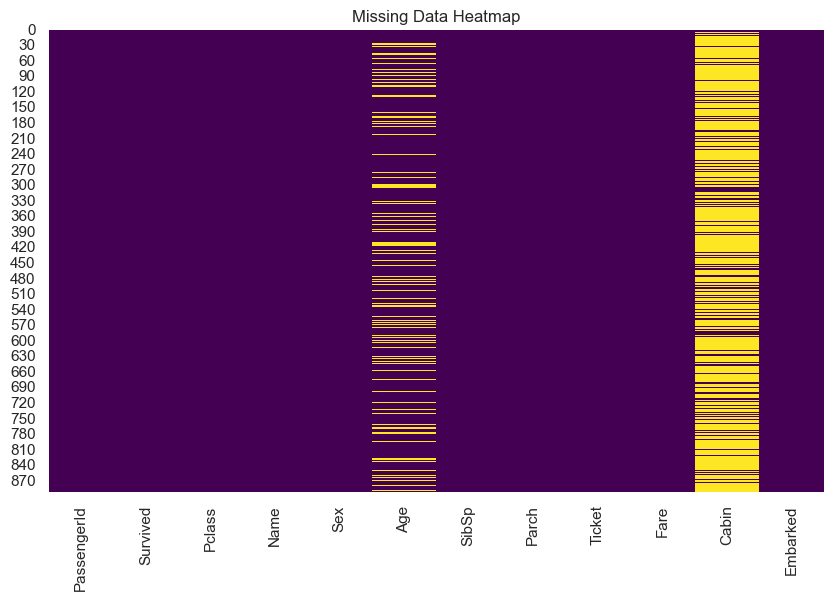

In [27]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()

---
## Step 4: Handle Missing Valuess

- **Age**: Fill missing values with the median age, grouped by `Pclass` and `Sex`.
- **Embarked**: Fill with the most frequent port (mode).
- **Cabin**: Dropped due to excessive missing values.

---

In [28]:
df['Age'] = df.groupby(['Pclass', 'Sex'])['Age'].transform(lambda x: x.fillna(x.median()))

In [29]:
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

C:\Users\rajat\AppData\Local\Temp\ipykernel_22080\3744086084.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)


In [30]:
df.drop(columns=['Cabin'], inplace=True)

---
## Step 5: Encode Categorical Variabless

Apply **One-Hot Encoding** to transform categorical variables into numerical format:

- Convert `Sex` and `Embarked` into binary indicator variables.
- Drop the first category to avoid multicollinearity.

---

In [31]:
encoded_df = pd.get_dummies(df, columns=['Sex', 'Embarked'], drop_first=True)

---
## Step 6: Feature Engineering)

Create two meaningful new features:

- **FamilySize**: Total family members on board = `SibSp + Parch + 1`
- **IsAlone**: Binary flag where 1 = passenger traveled alone

These features help capture social structure and survival influence.

---

In [32]:
encoded_df['FamilySize'] = encoded_df['SibSp'] + encoded_df['Parch'] + 1

In [33]:
encoded_df['IsAlone'] = (encoded_df['FamilySize'] == 1).astype(int)


---
## Step 7: Standardize Numerical Features

Normalize `Age`, `Fare`, and `FamilySize` using **StandardScaler** to:

- Improve model performance
- Ensure numerical features are on a comparable scale---l---
---


In [34]:
from sklearn.preprocessing import StandardScaler

In [35]:
scaler = StandardScaler()
num_features = ['Age', 'Fare', 'FamilySize']
encoded_df[num_features] = scaler.fit_transform(encoded_df[num_features])

---
## Step 8: Visualize Outliers

Use **boxplots** to identify outliers in `Age` and `Fare`. This helps inform the next step—outlier handling.

---


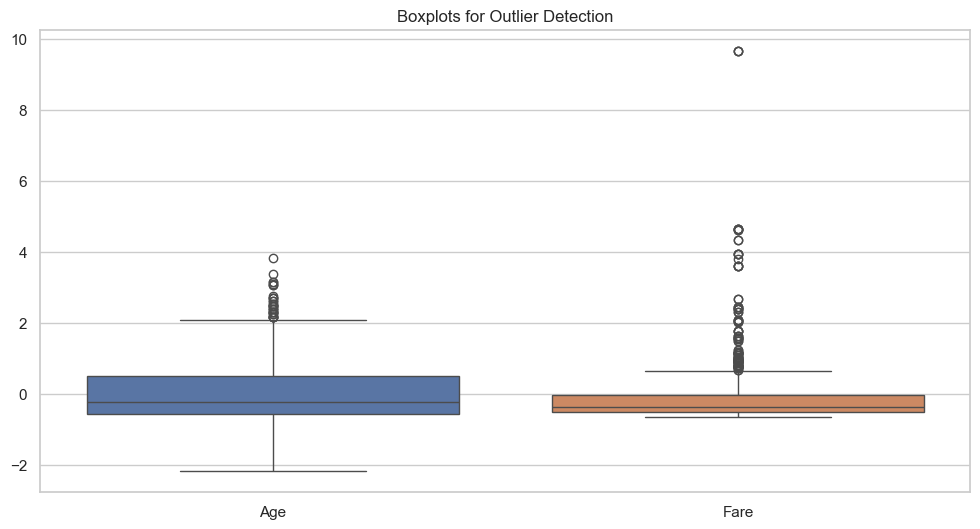

In [36]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=encoded_df[['Age', 'Fare']])
plt.title('Boxplots for Outlier Detection')
plt.show()

---
## Step 9: Drop Outliers Using IQR

Remove extreme outliers in the `Fare` column using the **Interquartile Range (IQR)** method:

- Identify and drop rows where `Fare` lies outside the IQR bounds.

---

In [37]:
Q1 = encoded_df['Fare'].quantile(0.25)
Q3 = encoded_df['Fare'].quantile(0.75)
IQR = Q3 - Q1
encoded_df = encoded_df[(encoded_df['Fare'] >= Q1 - 1.5 * IQR) & (encoded_df['Fare'] <= Q3 + 1.5 * IQR)]

---

## Step 10: Final Preview

Display the final cleaned dataset to verify all transformations are applied as expected.

---

In [38]:
print("\n--- Cleaned Data Preview ---")
encoded_df.head()


--- Cleaned Data Preview ---


,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Sex_male,Embarked_Q,Embarked_S,FamilySize,IsAlone
0,1,0,3,"Braund, Mr. Owen Harris",-0.534891,1,0,A/5 21171,-0.502445,True,False,True,0.059160,0
2,3,1,3,"Heikkinen, Miss. Laina",-0.234070,0,0,STON/O2. 3101282,-0.488854,False,False,True,-0.560975,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0.442776,1,0,113803,0.420730,False,False,True,0.059160,0
4,5,0,3,"Allen, Mr. William Henry",0.442776,0,0,373450,-0.486337,True,False,True,-0.560975,1
5,6,0,3,"Moran, Mr. James",-0.309276,0,0,330877,-0.478116,True,True,False,-0.560975,1


---


## Step 11: Save Cleaned Data

Save the cleaned and preprocessed dataset to a new CSV file for use in model training or further analysis.
.si---=False)
alse)

In [39]:
encoded_df.to_csv('Cleaned_Titanic.csv', index=False)